In [23]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.formula import api
import warnings 
warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('Walmart.csv')
display(df.head())
original_df = df.copy(deep=True)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [25]:
df.Date = pd.to_datetime(df.Date)

df['weekday'] = df.Date.dt.weekday
df['month'] = df.Date.dt.month
df['year'] = df.Date.dt.year

df.drop(['Date'], axis=1, inplace=True)#,'month'

target = 'Weekly_Sales'
features = [i for i in df.columns if i not in [target]]
original_df = df.copy(deep=True)

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   weekday       6435 non-null   int64  
 8   month         6435 non-null   int64  
 9   year          6435 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 502.9 KB


In [27]:
df.nunique().sort_values()

Holiday_Flag       2
year               3
weekday            7
month             12
Store             45
Unemployment     349
Fuel_Price       892
CPI             2145
Temperature     3528
Weekly_Sales    6435
dtype: int64

In [28]:
nu = df[features].nunique().sort_values()
nf = []
cf = []
nnf = 0 
ncf = 0

for i in range(df[features].shape[1]):
    if nu.values[i]<=45:cf.append(nu.index[i])
    else: nf.append(nu.index[i])
print(len(nf))
print(len(cf))

4
5


In [29]:
display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,3.573427,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.426581,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,0.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,6.000000,12.000000,2012.000000


/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


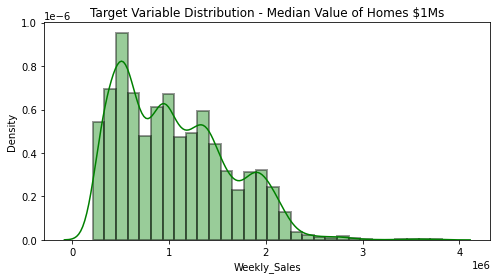

In [30]:
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes $1Ms')
plt.show()

/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinte

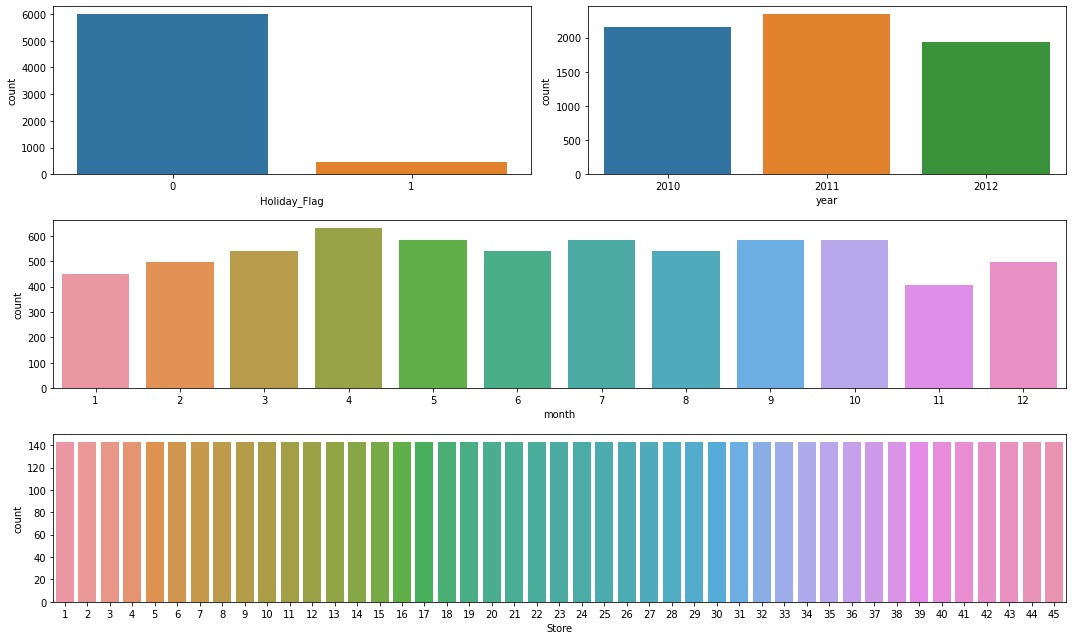

/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

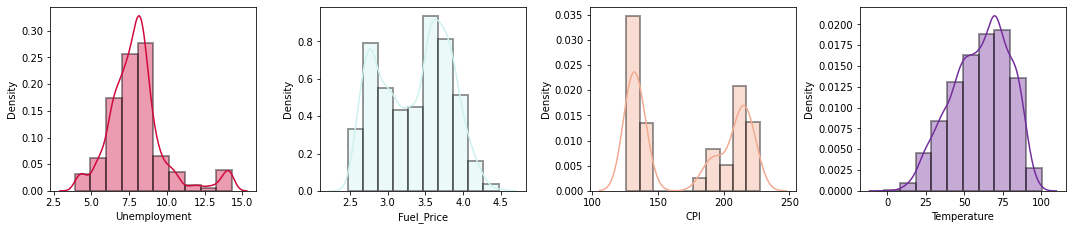

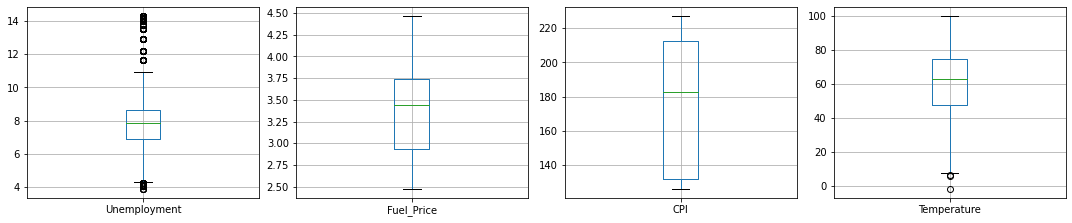

In [31]:
n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df[cf[i]].nunique()<=8:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])
    else:
        plt.subplot(3,1,i-1)
        sns.countplot(df[cf[i]])
        
plt.tight_layout()
plt.show()

n=4

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

In [32]:
counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

In [33]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (6435, 9) (6435,) 
Training set  --->  (5148, 9) (5148,) 
Testing set   --->  (1287, 9)  (1287,)


In [34]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03,5.148000e+03
mean,-1.035173e-16,7.522257e-17,-2.553427e-16,-1.449242e-16,-4.968830e-17,-1.849509e-16,9.799638e-17,2.898484e-17,-5.271929e-14
std,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00,1.000097e+00
min,-1.691819e+00,-2.786823e-01,-2.981747e+00,-1.922335e+00,-1.162931e+00,-2.221388e+00,-2.511182e+00,-1.655038e+00,-1.203861e+00
25%,-8.465737e-01,-2.786823e-01,-7.250120e-01,-9.275490e-01,-1.020104e+00,-5.955842e-01,2.982421e-01,-7.546748e-01,-1.203861e+00
50%,-1.328439e-03,-2.786823e-01,1.148294e-01,1.835670e-01,2.809851e-01,-6.492302e-02,2.982421e-01,-1.544329e-01,4.992749e-02
75%,8.439168e-01,-2.786823e-01,7.682801e-01,8.217521e-01,1.042883e+00,3.248191e-01,2.982421e-01,7.459300e-01,1.303716e+00
max,1.689162e+00,3.588316e+00,2.140202e+00,2.417758e+00,1.406786e+00,3.379946e+00,1.702954e+00,1.646293e+00,1.303716e+00



                                          Standardardization on Testing set                                          


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekday,month,year
count,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000,1287.000000
mean,-0.006642,-0.041314,0.025211,0.027495,-0.033202,-0.047740,-0.006822,-0.058590,0.030444
std,0.990027,0.928563,0.996777,0.990103,0.998831,1.033862,1.009789,0.983202,0.996091
min,-1.691819,-0.278682,-3.393540,-1.831010,-1.162931,-2.221388,-2.511182,-1.655038,-1.203861
25%,-0.846574,-0.278682,-0.666765,-0.907979,-1.016097,-0.623768,0.298242,-0.754675,-1.203861
50%,-0.001328,-0.278682,0.111037,0.230317,-0.742990,-0.081028,0.298242,-0.154433,0.049927
75%,0.882337,-0.278682,0.813794,0.843496,1.016348,0.296635,0.298242,0.745930,1.303716
max,1.689162,3.588316,2.143994,2.417758,1.407256,3.379946,1.702954,1.646293,1.303716


                                       Correlation Matrix                                       


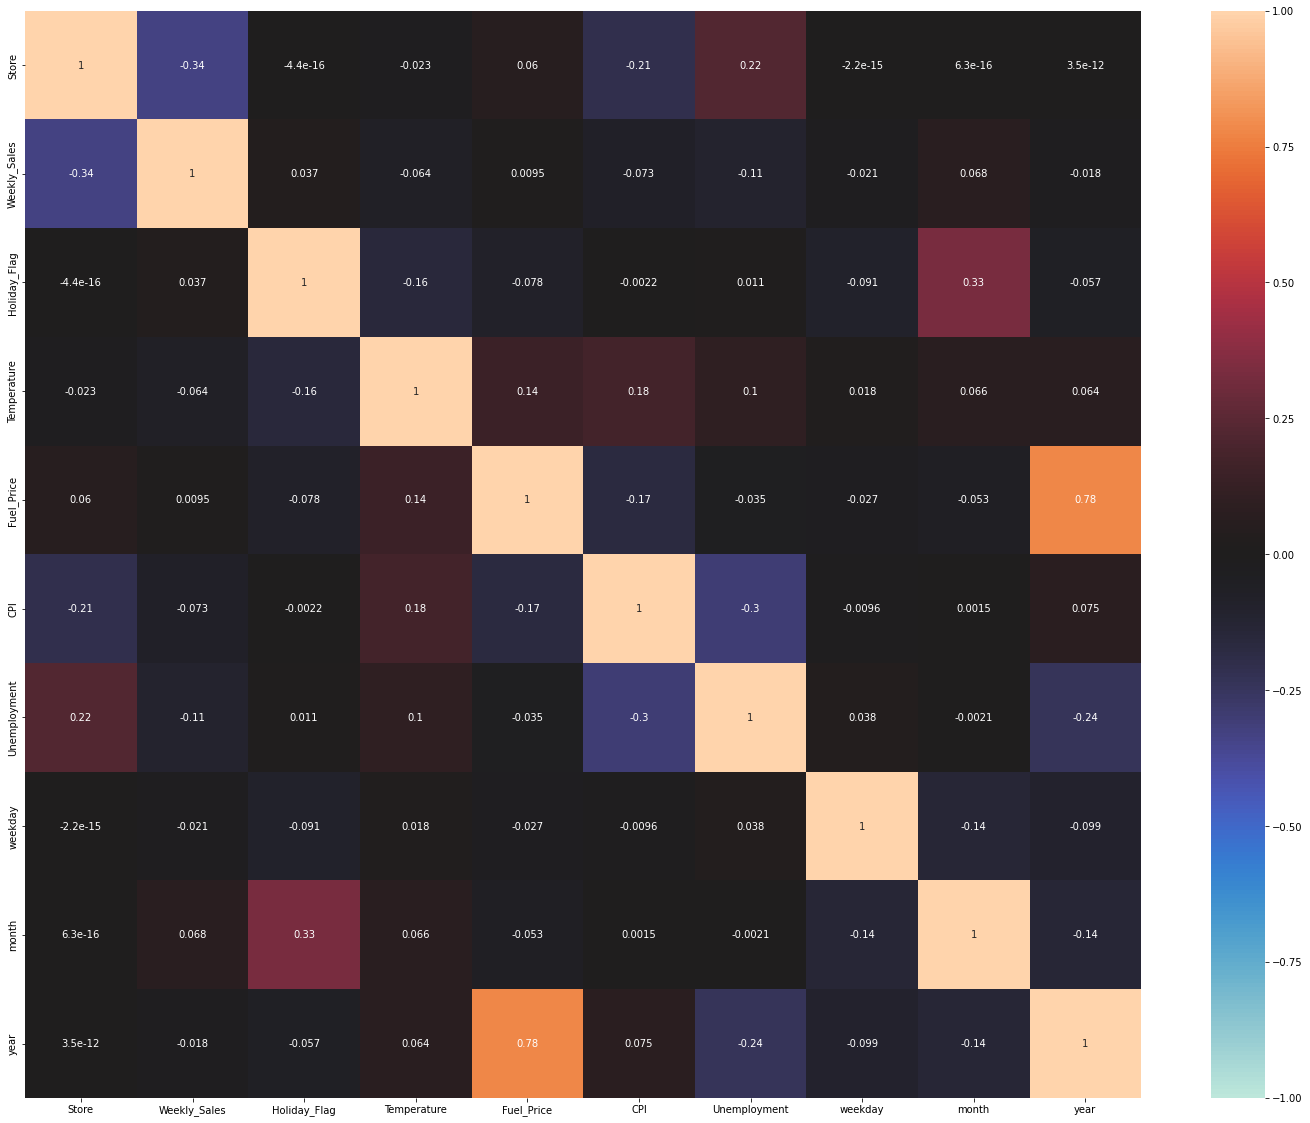

In [35]:
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

In [36]:
Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Weekly_Sales   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     97.33
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          2.03e-168
Time:                        23:43:44   Log-Likelihood:                -75066.
No. Observations:                5148   AIC:                         1.502e+05
Df Residuals:                    5138   BIC:                         1.502e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.051e+06   7262.095    144.713      0.000    1.04e+06    1.07e+06
Store        -1.997e+05   7568.430    -26.388      0.000   -2.15e+05   -1.85e+05
Holiday_Flag  8877.5142   7901.611      1.124      0.261   -6613.007    2.44e+04
Temperature  -2.283e+04   7838.881     -2.912      0.004   -3.82e+04   -7461.303
Fuel_Price    3.119e+04   1.32e+04      2.361      0.018    5292.934    5.71e+04
CPI          -7.883e+04   8437.498     -9.343      0.000   -9.54e+04   -6.23e+04
Unemployment -4.484e+04   8207.383     -5.463      0.000   -6.09e+04   -2.87e+04
weekday      -6972.1516   7439.027     -0.937      0.349   -2.16e+04    7611.508
month         3.258e+04   8002.228      4.071      0.000    1.69e+04    4.83e+04
year         -3.912e+04   1.33e+04     -2.932      0.003   -6.53e+04    -1.3e+04
==============================================================================
Omnibus:                      125.404   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.298
Skew:                           0.395   Prob(JB):                     6.88e-30
Kurtosis:                       3.032   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

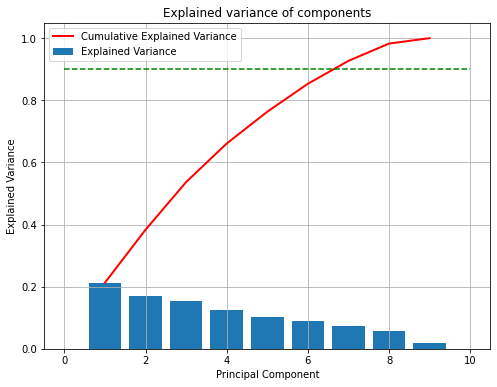

In [37]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

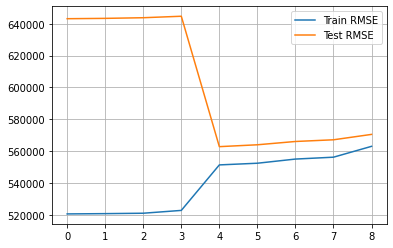

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()

# <center> 6. Predictive Modelling

In [40]:
Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1050918.2283119638


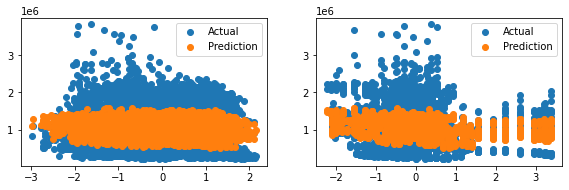



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.14565826905132617
Residual Sum of Squares (RSS) on Training set  ---> 1394943179150632.0
Mean Squared Error (MSE) on Training set       ---> 270967983517.99377
Root Mean Squared Error (RMSE) on Training set ---> 520545.8515039705

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.15008962808512905
Residual Sum of Squares (RSS) on Training set  ---> 353664235836290.75
Mean Squared Error (MSE) on Training set       ---> 274797386042.18396
Root Mean Squared Error (RMSE) on Training set ---> 524211.20365954016

--------------------Residual Plots--------------------


/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


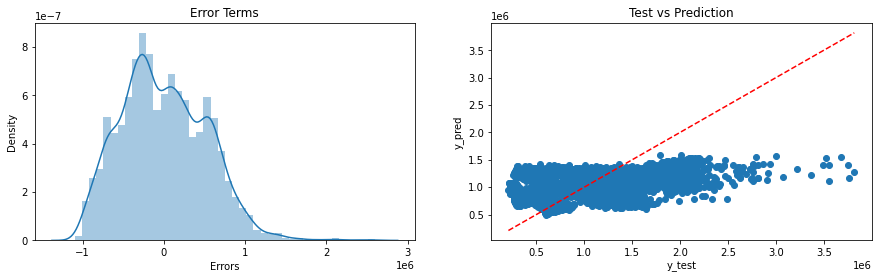

In [41]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1050918.2283119638


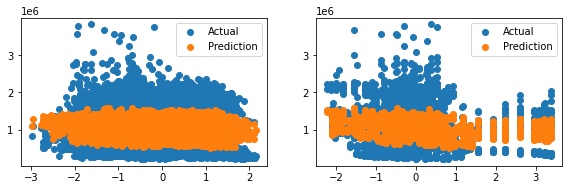



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.14565826103677293
Residual Sum of Squares (RSS) on Training set  ---> 1394943192236550.5
Mean Squared Error (MSE) on Training set       ---> 270967986059.936
Root Mean Squared Error (RMSE) on Training set ---> 520545.8539455828

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.15008613152622974
Residual Sum of Squares (RSS) on Training set  ---> 353665690822454.06
Mean Squared Error (MSE) on Training set       ---> 274798516567.5634
Root Mean Squared Error (RMSE) on Training set ---> 524212.2819693978

--------------------Residual Plots--------------------


/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


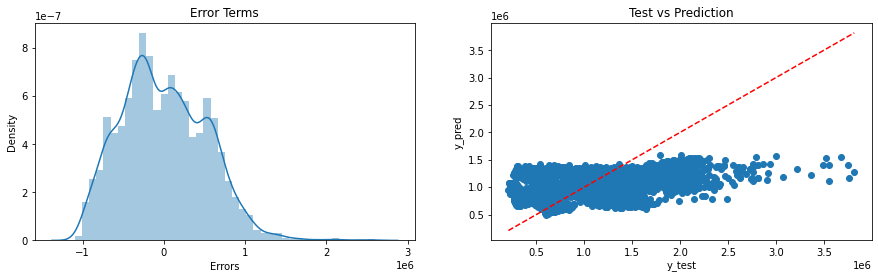

In [42]:
RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1050918.2283119638


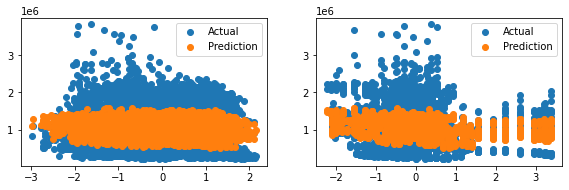



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.1456582689923004
Residual Sum of Squares (RSS) on Training set  ---> 1394943179247007.5
Mean Squared Error (MSE) on Training set       ---> 270967983536.71472
Root Mean Squared Error (RMSE) on Training set ---> 520545.8515219526

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.1500892568146427
Residual Sum of Squares (RSS) on Training set  ---> 353664390329161.06
Mean Squared Error (MSE) on Training set       ---> 274797506083.26422
Root Mean Squared Error (RMSE) on Training set ---> 524211.31815639406

--------------------Residual Plots--------------------


/Users/atakanfilgoz/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


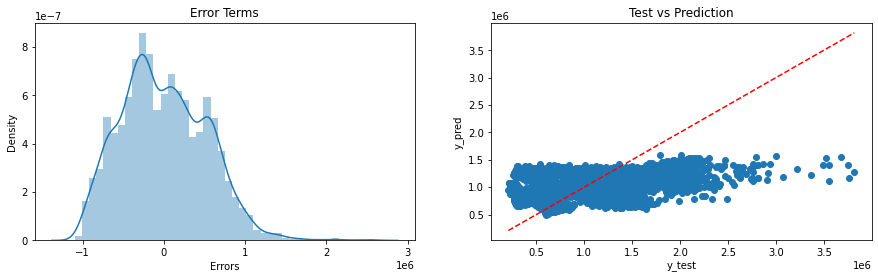

In [43]:
LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

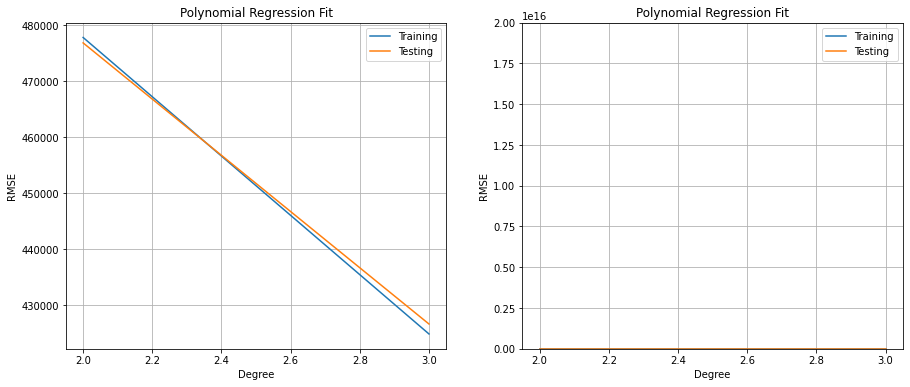

In [44]:
Trr=[]; Tss=[]
n_degree=4

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,2e16])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()